In [1]:
import os
import glob
import hashlib
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.measure import shannon_entropy
from skimage import io

In [2]:
# Fonctions de mesure des caractéristiques d'image
def variance_of_laplacian(image):
    """
    Calcul de la variance du Laplacien pour évaluer la netteté de l'image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()

def tenengrad(image):
    """
    Mesure de la netteté de l'image avec les filtres de Sobel.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    return np.mean(gradient_magnitude)

def brightness(image):
    """
    Mesure de la luminosité moyenne d'une image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

def estimate_noise(image):
    """
    Estimation du bruit d'une image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    noise = gray - blurred
    return np.std(noise)

def snr(image):
    """
    Calcul du rapport signal sur bruit (SNR) d'une image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_signal = np.mean(gray)
    noise = gray - cv2.GaussianBlur(gray, (3, 3), 0)
    noise_std = np.std(noise)
    return mean_signal / noise_std

def contraste(image):
    """
    Calcul du contraste d'une image en niveaux de gris.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.std(gray)

def entropie(image_path):
    """
    Calcul de l'entropie de Shannon d'une image pour évaluer sa complexité.
    """
    image = io.imread(image_path, as_gray=True)
    return shannon_entropy(image)

def saturation(image):
    """
    Calcul de la saturation moyenne d'une image pour évaluer la richesse des couleurs.
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return hsv_image[:, :, 1].mean()

          sharpness         sobel    brightness         noise           snr  \
count  54303.000000  54303.000000  54303.000000  54303.000000  54303.000000   
mean    3813.553265     67.667131    120.703989    119.651939      1.009356   
std     3576.296836     25.666125     19.509071      3.408372      0.166654   
min        4.659030      8.831932      8.246216     57.438463      0.138736   
25%      910.393366     47.268886    108.755745    118.035927      0.902036   
50%     3061.415518     67.187766    119.878571    120.116819      1.004527   
75%     5780.254361     86.215938    130.888313    122.091958      1.101466   
max    27109.052995    220.185111    235.058762    124.569545      2.124216   

           contrast       entropy    saturation  
count  54303.000000  54303.000000  54303.000000  
mean      40.170087     12.320267     69.074008  
std       11.593207      0.960753     21.476765  
min        7.456203      2.016120     12.715027  
25%       31.446404     11.726560     

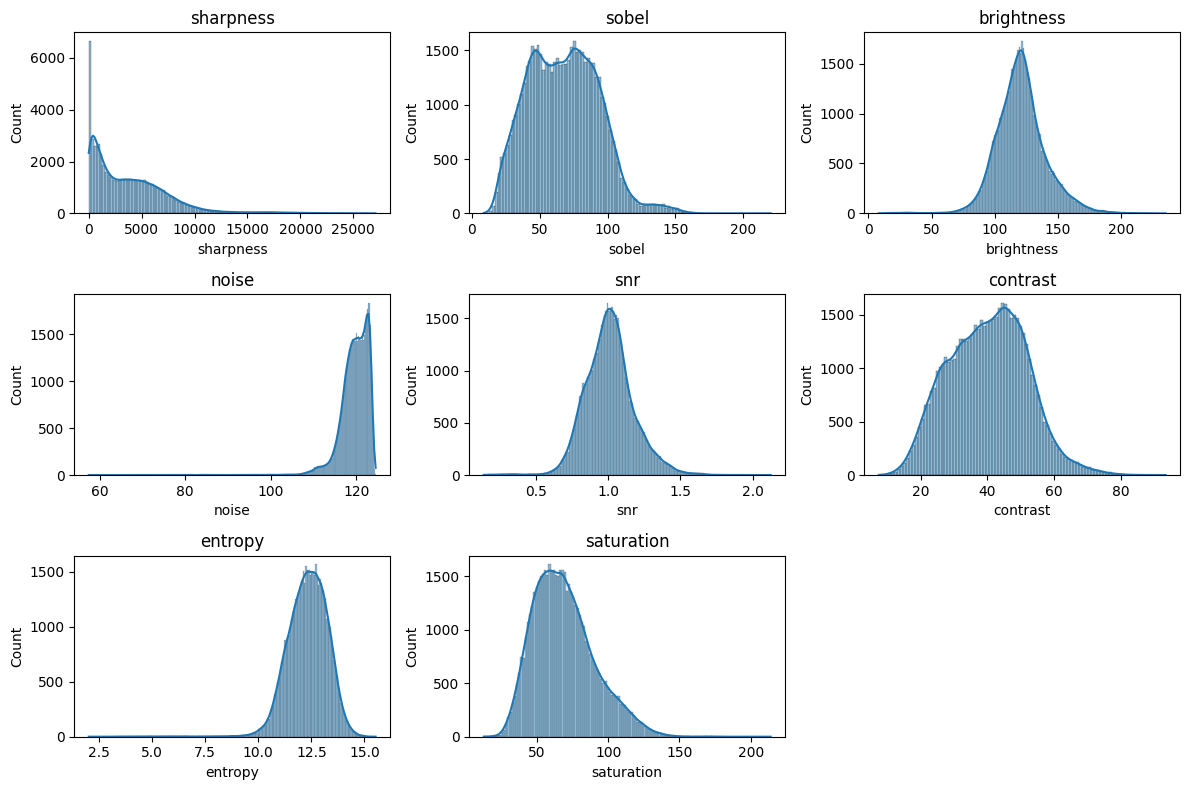

In [3]:
# Chemin du répertoire contenant les images
repertoire = r'D:\aprojet\fev24_cds_plants\data\color'

# Liste pour stocker les informations sur les images
results = []

# Parcours des sous-répertoires et des fichiers
for dossier, sous_dossiers, fichiers in os.walk(repertoire):
    for nom_fichier in glob.glob(os.path.join(dossier, '*.jpg')):
        chemin_image = nom_fichier
        nom_image = os.path.basename(nom_fichier)

        image = cv2.imread(nom_fichier)
        if image is None:
            print(f"Could not read image {nom_fichier}")
            continue

        # Calcul des métriques d'image
        metrics = {
            'image_path': nom_fichier,
            'sharpness': variance_of_laplacian(image),
            'sobel': tenengrad(image),
            'brightness': brightness(image),
            'noise': estimate_noise(image),
            'snr': snr(image),
            'contrast': contraste(image),
            'entropy': entropie(chemin_image),
            'saturation': saturation(image)
        }

        results.append(metrics)

# Création du DataFrame à partir des résultats
df = pd.DataFrame(results)

# Sauvegarde des métriques dans un fichier CSV
output_csv = 'metriques.csv'
df.to_csv(output_csv, index=False)

# Chargement des métriques depuis le fichier CSV
metriques = pd.read_csv(output_csv)

# Affichage des statistiques descriptives
print(metriques.describe())

# Visualisation des distributions des métriques
plt.figure(figsize=(12, 8))
for i, feature in enumerate(metriques.columns[1:], 1):
    plt.subplot(3, 3, i)
    sns.histplot(metriques[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()